# retraining mobilenet with more images by rearrangin dataset from kaggle

In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [9]:
# Paths to the dataset
data_dir = 'augmented_data_II'

# Hyperparameters
img_size = 224  # MobileNet standard input size
batch_size = 32
epochs = 10
learning_rate = 0.0001


In [10]:
# Data augmentation and rescaling
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Creating the training and validation generators
train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (yes/no)
    subset='training'     # Set this as training set
)

validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (yes/no)
    subset='validation'   # Set this as validation set
)


Found 6810 images belonging to 2 classes.
Found 1702 images belonging to 2 classes.


In [11]:
# Load MobileNet model without top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base layers (fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (yes/no)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)


In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [13]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 120s 555ms/step - accuracy: 0.8682 - loss: 0.2838 - val_accuracy: 0.9009 - val_loss: 0.2837
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.9062 - loss: 0.1776 - val_accuracy: 1.0000 - val_loss: 0.0202
Epoch 3/10


D:\Python\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


212/212 ━━━━━━━━━━━━━━━━━━━━ 118s 557ms/step - accuracy: 0.9756 - loss: 0.0868 - val_accuracy: 0.9045 - val_loss: 0.2702
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.9688 - loss: 0.0463 - val_accuracy: 1.0000 - val_loss: 0.0935
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 117s 553ms/step - accuracy: 0.9854 - loss: 0.0528 - val_accuracy: 0.9204 - val_loss: 0.2227


In [15]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.9069 - loss: 0.2691
Validation Accuracy: 90.25%


In [16]:
# After training the model, save it to an .h5 file
model.save('brain_tumor_detection_mobilenet.h5')
print("Model saved successfully as brain_tumor_detection_mobilenet.h5")


Model saved successfully as brain_tumor_detection_mobilenet.h5


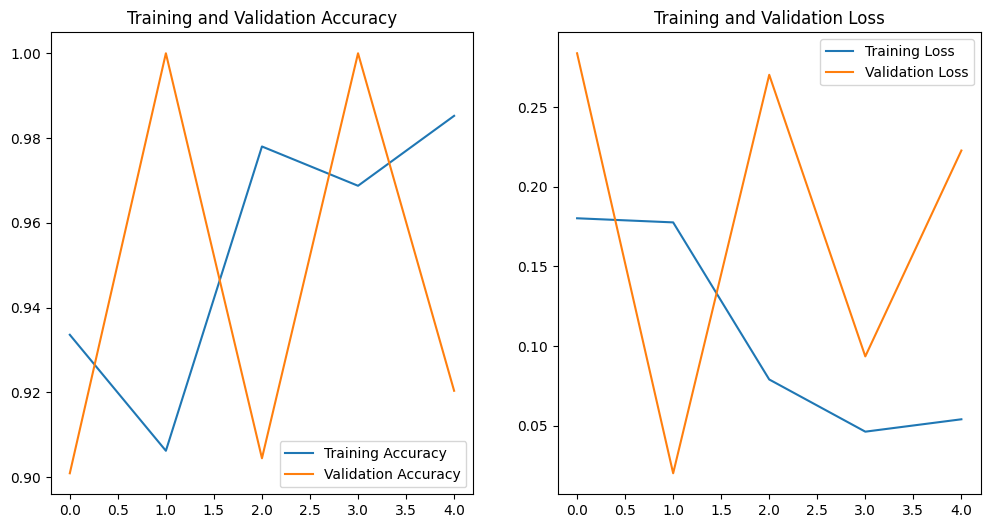

In [17]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# testing and confusion matrix with f1_score

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [19]:
model = load_model('brain_tumor_detection_mobilenet.h5')  


In [21]:
# Get predictions on validation data
Y_val_pred = model.predict(validation_generator)
y_val_pred = (Y_val_pred > 0.5).astype(int).flatten()  # Binary classification threshold

# Get true labels from validation set
y_val_true = validation_generator.classes
class_labels = ['No', 'Yes']  # Assuming 'No' for no tumor, 'Yes' for tumor


54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 435ms/step


In [22]:
from sklearn.metrics import f1_score, classification_report

# Calculate F1 score for validation data
f1_val = f1_score(y_val_true, y_val_pred)
print(f"F1 Score on validation data: {f1_val:.4f}")

# Print detailed classification report
print(classification_report(y_val_true, y_val_pred, target_names=class_labels))


F1 Score on validation data: 0.6771
              precision    recall  f1-score   support

          No       0.35      0.29      0.32       599
         Yes       0.65      0.71      0.68      1103

    accuracy                           0.56      1702
   macro avg       0.50      0.50      0.50      1702
weighted avg       0.54      0.56      0.55      1702



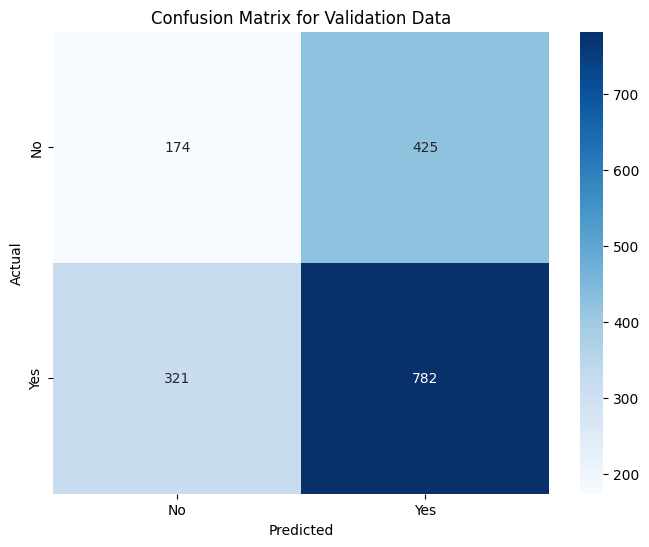

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix_val = confusion_matrix(y_val_true, y_val_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Data')
plt.show()


In [26]:
# Get predictions on validation data
Y_val_pred = model.predict(train_generator)
y_val_pred = (Y_val_pred > 0.5).astype(int).flatten()  # Binary classification threshold

# Get true labels from validation set
y_val_true = train_generator.classes
class_labels = ['No', 'Yes']  # Assuming 'No' for no tumor, 'Yes' for tumor


213/213 ━━━━━━━━━━━━━━━━━━━━ 93s 434ms/step


In [27]:
from sklearn.metrics import f1_score, classification_report

# Calculate F1 score for validation data
f1_val = f1_score(y_val_true, y_val_pred)
print(f"F1 Score on validation data: {f1_val:.4f}")

# Print detailed classification report
print(classification_report(y_val_true, y_val_pred, target_names=class_labels))


F1 Score on validation data: 0.6445
              precision    recall  f1-score   support

          No       0.35      0.35      0.35      2396
         Yes       0.65      0.64      0.64      4414

    accuracy                           0.54      6810
   macro avg       0.50      0.50      0.50      6810
weighted avg       0.54      0.54      0.54      6810

